# INTRODUCTION

We have data which classifies patients as either having heart disease or not along with several demographics and cardiac disease risk factors. We will try to use this data to create a model which can be used to predict if a patient has this disease or not. We will mainly use the logistic regression (classification) algorithm, and briefly compare other methods.

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from plotnine import *
import statsmodels.api as sm
from statsmodels.formula.api import ols

np.random.seed(123) #ensure reproducibility

#ignore errors about using jupyter notebook or sample size being too small
import warnings
warnings.simplefilter("ignore", UserWarning) 

In [5]:
mpl.rcParams.update({'errorbar.capsize': 5})

# styles from: https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')
# plt.style.use('ggplot')
# plt.style.use('fivethirtyeight')
# plt.style.use('default')

sns.set_style("whitegrid")
sns.set(font_scale=1.4)

In [6]:
df = pd.read_csv('data_clean.csv')

In [7]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,1,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,0,2
2,67,1,3,120,229,0,2,129,1,2.6,1,2,2,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,0,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,0,0


In [8]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,2.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,0.600660,0.663366,0.831683,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,0.956705,1.228536
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,2.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,4.000000


It's a clean and easy to understand set of data. However, the meaning of some of the column headers are not obvious:

- **age**: The patient's age in years
- **sex**: The patient's sex 
  - 0 = female
  - 1 = male
- **cp:** The chest pain experienced 
  - 0 = typical angina
  - 1 = atypical angina
  - 2 = non-anginal pain
  - 3 = asymptomatic
- **trestbps:** The patient's resting systolic blood pressure (on admission)
- **chol:** The patient's cholesterol measurement in mg/dl
- **fbs:** The patient's fasting blood sugar
  - 0 = <120 mg/dl, 
  - 1 = >120 mg/dl
- **restecg:** Resting ECG measurement 
  - 0 = normal
  - 1 = ST-T wave abnormality
  - 2 = showing probable or definite left ventricular hypertrophy (by Estes' criteria)
- **thalach:** The patient's maximum heart rate achieved
- **exang:** Exercise induced angina 
  - 0 = no
  - 1 = yes
- **oldpeak:** ST depression induced by exercise relative to rest
- **slope:** The slope of the peak exercise ST segment 
  - 0 = upsloping
  - 1 = flat
  - 2 = downsloping
- **ca:** The number of major vessels (0-3) colored by fluorosopy
- **thal:** Thallium cardiac scan 
  - 0 = normal
  - 1 = fixed defect
  - 2 = reversable defect
- **target:** Heart disease 
  - 0 = <50% diameter narrowing
  - 1 = >50% diameter narrowing

Therefore let us adjust the columns and values to make them more human friendly:

In [9]:
df.columns = [
    'age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 
    'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 
    'max_heart_rate_achieved', 'exercise_induced_angina', 
    'st_depression', 'st_slope', 'num_major_vessels', 
    'thallium', 'target'
]
df.describe()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thallium,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,2.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,0.600660,0.663366,0.831683,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,0.956705,1.228536
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,2.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,4.000000


In [10]:
df2 = df.copy()
df2['sex'] = df['sex'].replace([0,1],['male','female'])

df2['chest_pain_type']= df['chest_pain_type'] \
    .replace(0,'typical angina') \
    .replace(1,'atypical angina') \
    .replace(2,'non-anginal pain') \
    .replace(3, 'asymptomatic')

df2['fasting_blood_sugar'] = df['fasting_blood_sugar'] \
    .replace(0, '< 120mg/ml') \
    .replace(1, '> 120mg/ml')

df2['rest_ecg'] = df['rest_ecg'] \
    .replace(0, 'normal') \
    .replace(1, 'ST-T wave abnormality') \
    .replace(2, 'left ventricular hypertrophy')

df2['exercise_induced_angina'] = df['exercise_induced_angina'] \
    .replace([0,1], ['no','yes']) 

df2['st_slope'] = df['st_slope'] \
    .replace([0,1,2], ['upsloping','flat','downsloping'])

df2['thallium'] = df['thallium'] \
    .replace([0,1,2], ['normal','fixed defect', 'reversible defect'])

df2['target'] = df['target'] \
    .replace(0, 'no disease') \
    .replace([1,2,3,4], ['heart disease']*4)

In [11]:
df2.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thallium,target
0,63,female,typical angina,145,233,> 120mg/ml,left ventricular hypertrophy,150,no,2.3,downsloping,0,fixed defect,no disease
1,67,female,asymptomatic,160,286,< 120mg/ml,left ventricular hypertrophy,108,yes,1.5,flat,3,normal,heart disease
2,67,female,asymptomatic,120,229,< 120mg/ml,left ventricular hypertrophy,129,yes,2.6,flat,2,reversible defect,heart disease
3,37,female,non-anginal pain,130,250,< 120mg/ml,normal,187,no,3.5,downsloping,0,normal,no disease
4,41,male,atypical angina,130,204,< 120mg/ml,left ventricular hypertrophy,172,no,1.4,upsloping,0,normal,no disease


In [12]:
df2.groupby('target').mean()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels
target,,,,,,
heart disease,56.625899,134.568345,251.474820,139.258993,1.574101,1.129496
no disease,52.585366,129.250000,242.640244,158.378049,0.586585,0.268293


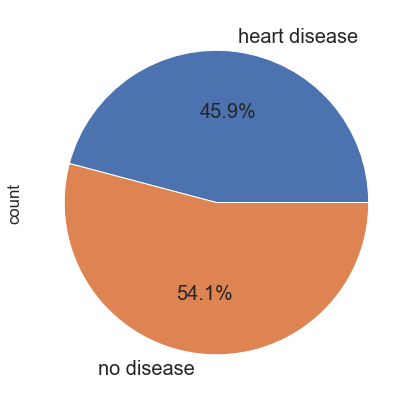

In [13]:
fig = df2.groupby('target')['age'].describe()['count'].plot(kind='pie', 
                                                            figsize=(7,7), 
                                                            autopct='%1.1f%%', 
                                                            textprops={'fontsize': 20})
plt.show()

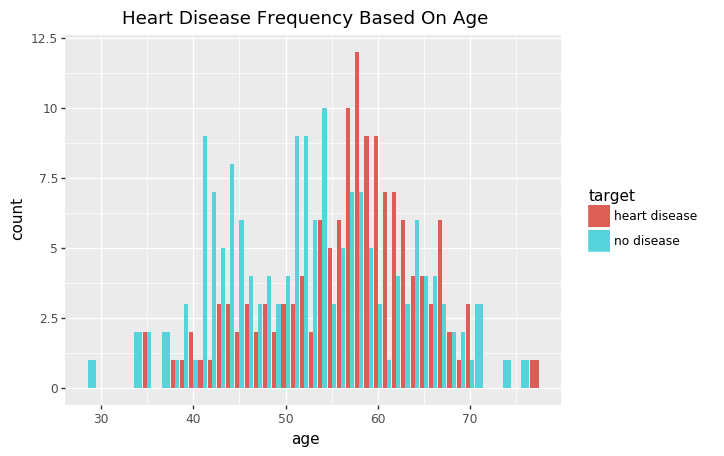

In [14]:
fig = (ggplot(df2, aes(x='age', fill='target'))
       + geom_bar(position='dodge')
       + labs(title='Heart Disease Frequency Based On Age')
      ).draw()
fig.show()

In [15]:
age = df2['age'].describe()
age_range = age['max']- age['min']
age_range

48.0

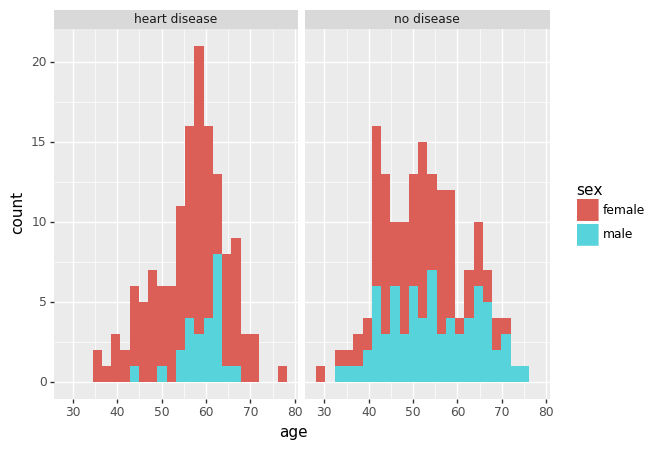

In [16]:
fig = (ggplot(df2, aes(x='age', fill='sex'))
       + geom_histogram(bins=age_range/2)
       + facet_grid('~ target')
      ).draw()
fig.show()

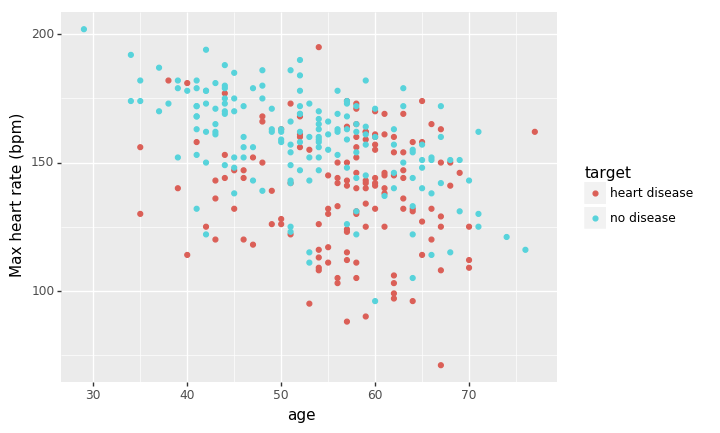

In [17]:
fig = (ggplot(df2, aes(x='age', y='max_heart_rate_achieved', colour='target'))
       + geom_point()
       + labs(y='Max heart rate (bpm)')
      ).draw()
fig.show()

In [18]:
df2.groupby('st_slope')['target'].describe()

,count,unique,top,freq
st_slope,,,,
downsloping,21,2,heart disease,12
flat,140,2,heart disease,91
upsloping,142,2,no disease,106


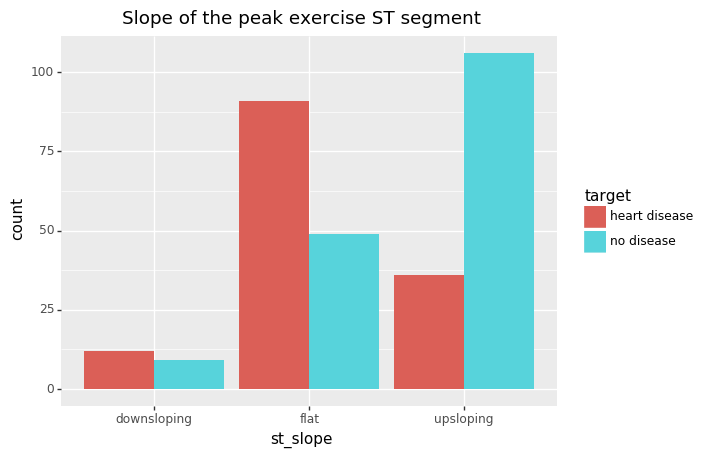

In [19]:
fig = (ggplot(df2, aes(x='st_slope', fill='target'))
       + geom_bar(position='dodge')
       + labs(title='Slope of the peak exercise ST segment')
      ).draw()
fig.show()

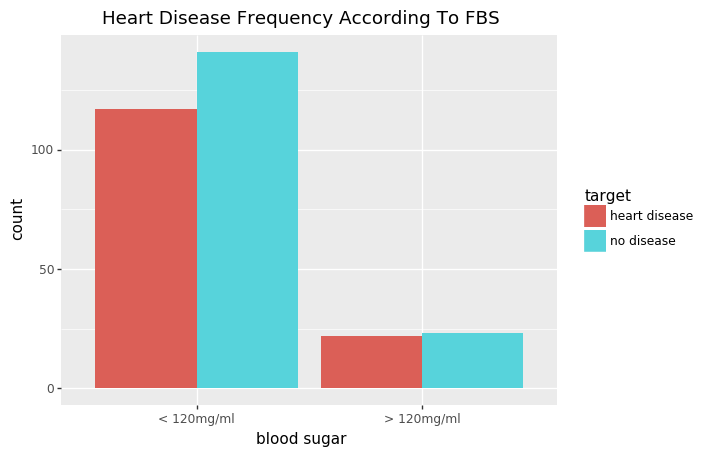

In [20]:
fig = (ggplot(df2, aes(x='fasting_blood_sugar', fill='target'))
       + geom_bar(position='dodge')
       + labs(title='Heart Disease Frequency According To FBS', x='blood sugar')
      ).draw()
fig.show()

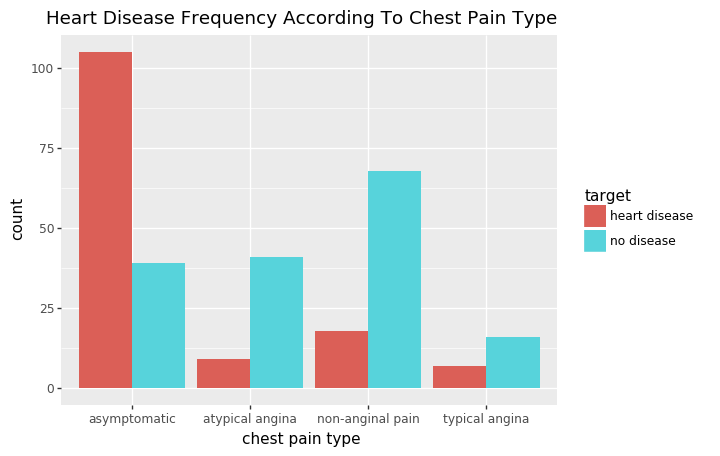

In [21]:
fig = (ggplot(df2, aes(x='chest_pain_type', fill='target'))
       + geom_bar(position='dodge')
       + labs(title='Heart Disease Frequency According To Chest Pain Type', x='chest pain type')
      ).draw()
fig.show()

# Introduction to Logistic Regression
Logistic regression models are used to analyze the relationship between a dependent variable (DV) and independent variable(s) (IV) when the DV is dichotomous. The DV is the outcome variable, a.k.a. the predicted variable, and the IV(s) are the variables that are believed to have an influence on the outcome, a.k.a. predictor variables. If the model contains 1 IV, then it is a simple logistic regression model, and if the model contains 2+ IVs, then it is a multiple logistic regression model.

Assumptions for logistic regression models:

* The DV is categorical (binary)
  * If there are more than 2 categories in terms of types of outcome, a multinomial logistic regression should be used
* Independence of observations
  * Cannot be a repeated measures design, i.e. collecting outcomes at two different time points.
* Independent variables are linearly related to the log odds
* Absence of multicollinearity
* Lack of outliers

The DV is `target` (does the patient have coronary artery disease) and the IVs are all the variables:

In [22]:
df2.columns.to_list()[:-1]

['age',
 'sex',
 'chest_pain_type',
 'resting_blood_pressure',
 'cholesterol',
 'fasting_blood_sugar',
 'rest_ecg',
 'max_heart_rate_achieved',
 'exercise_induced_angina',
 'st_depression',
 'st_slope',
 'num_major_vessels',
 'thallium']

In [23]:
df.describe()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thallium,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,2.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,0.600660,0.663366,0.831683,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,0.956705,1.228536
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,2.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,4.000000


Looking at the descriptive statistics, of the 303 patients, 54% of the patients had CAD (target).

One thing to keep in mind is that there are several variables that are truly categorical, which we have previously converted from their integer representation to strings. We will need to convert these data types to accurately be included in our model. This can be done with the helper function `pd.get_dummies()`. It automatically creates a new variable for each category type of the original variable and codes new dummy variables where 1 is membership to that category and 0 is non-membership.

In [24]:
categorical = [
    'chest_pain_type',
    'rest_ecg',
    'st_slope',
    'thallium'
]
df_cat = df.copy()
for category in categorical:
    df_cat[category] = df_cat[category].astype('category')
df_cat.dtypes

age                           int64
sex                           int64
chest_pain_type            category
resting_blood_pressure        int64
cholesterol                   int64
fasting_blood_sugar           int64
rest_ecg                   category
max_heart_rate_achieved       int64
exercise_induced_angina       int64
st_depression               float64
st_slope                   category
num_major_vessels             int64
thallium                   category
target                        int64
dtype: object

In [25]:
df_cat = pd.get_dummies(df_cat)
df_cat.columns.to_list()

['age',
 'sex',
 'resting_blood_pressure',
 'cholesterol',
 'fasting_blood_sugar',
 'max_heart_rate_achieved',
 'exercise_induced_angina',
 'st_depression',
 'num_major_vessels',
 'target',
 'chest_pain_type_0',
 'chest_pain_type_1',
 'chest_pain_type_2',
 'chest_pain_type_3',
 'rest_ecg_0',
 'rest_ecg_1',
 'rest_ecg_2',
 'st_slope_0',
 'st_slope_1',
 'st_slope_2',
 'thallium_0',
 'thallium_1',
 'thallium_2']

In [26]:
df_cat.columns = [
    'age',
     'sex',
     'resting_blood_pressure',
     'cholesterol',
     'fasting_blood_sugar',
     'max_heart_rate_achieved',
     'exercise_induced_angina',
     'st_depression',
     'num_major_vessels',
     'target',
     'cp_typical_angina',
     'cp_atypical_angina',
     'cp_non_anginal',
     'cp_asymmetric',
     'ecg_normal',
     'ecg_ischemic',
     'ecg_LVH',
     'st_upsloping',
     'st_flat',
     'st_downsloping',
     'thal_normal',
     'thal_fixed_defect',
     'thal_reversible',
]
df_cat['disease'] = df_cat['target']
df_cat.loc[df_cat['disease'] > 0, 'disease'] = 1

## Multiple Logistic Regression Checks
First the assumptions of the model need to be checked. We already know that (1) **DV is categorical** (target - binary), and (2) we know there is **indepdence of observations** (different patients).

Let's check the rest of the assumptions!

### Assumption of continuous IVs being linearly related to the log odds
Logistic regression does not require the continuous IV(s) to be linearly related to the DV. It does require the continuous IV(s) be linearly related to the log odds of the IV though. A way to test this is to plot the IV(s) in question and look for an S-shaped curve. Sometimes the S-shape will not be obvious. The plot should have a flat or flat-ish top and bottom with an increase or decreasing middle.

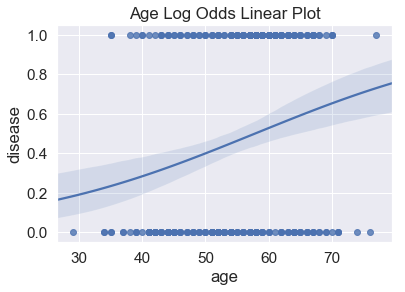

In [27]:
g = sns.regplot(x='age', 
                y='disease', 
                data= df_cat, logistic= True)
g.set_title("Age Log Odds Linear Plot")
plt.show()

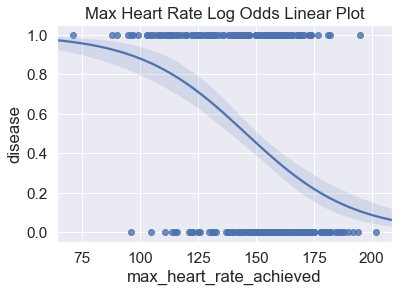

In [28]:
g = sns.regplot(x='max_heart_rate_achieved', 
                y='disease', 
                data= df_cat, logistic= True)
g.set_title("Max Heart Rate Log Odds Linear Plot")
plt.show()

### Assumption of Absence of Multicollinearity
An easy way to test this is to use a correlation matrix, and look for any highly correlated variables, and/or to look at for high Variance Inflation Factor (VIF) scores. If there are variables that are highly correlated, or have a high VIF, a corrective action would be to drop one of them since they are measuring the same/similar thing.

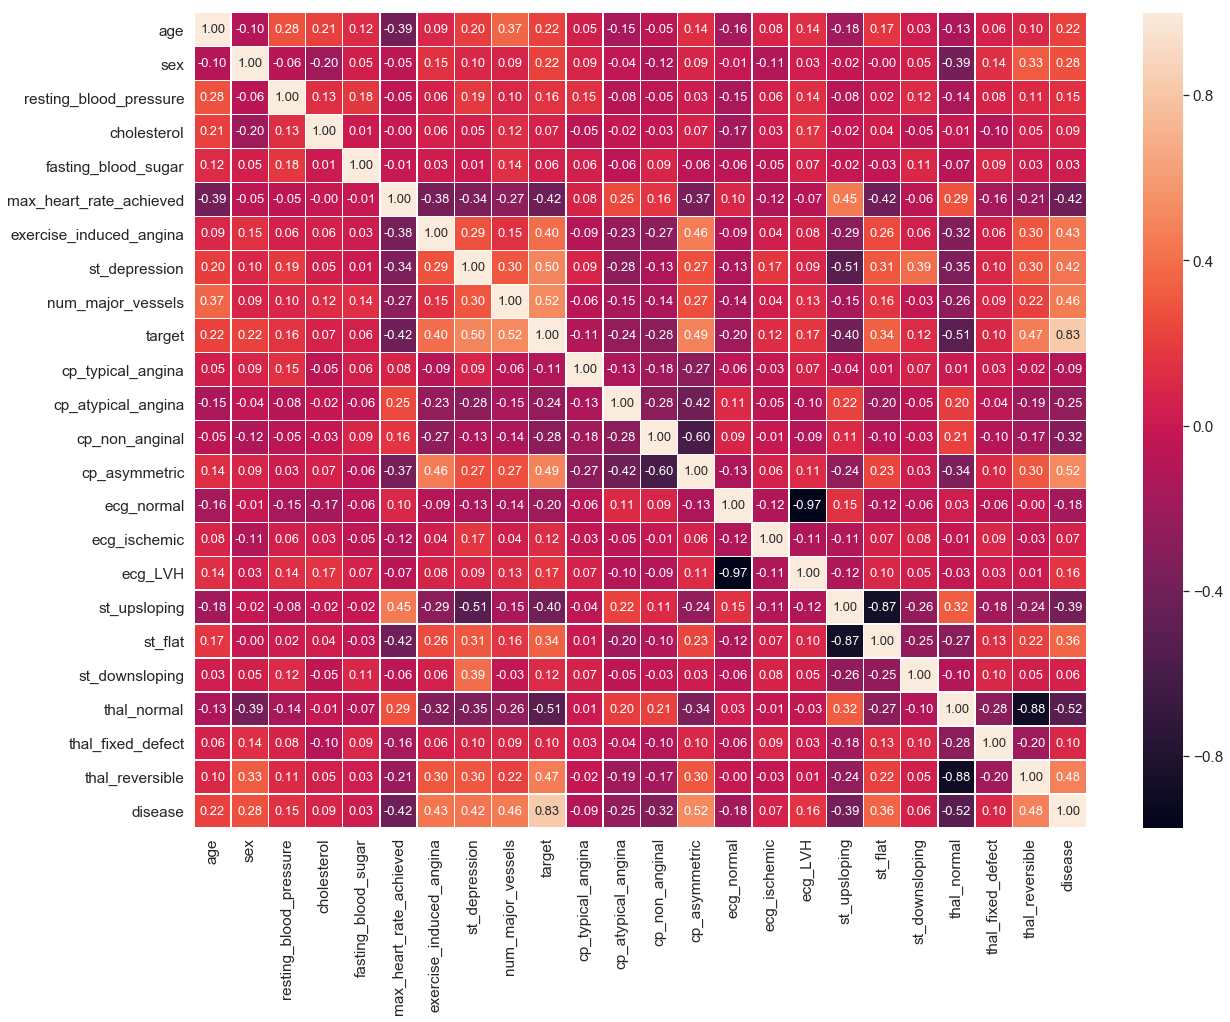

In [29]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(df_cat.corr(), annot=True, fmt=".2f", linewidths=.5, annot_kws={"size": 13}, ax=ax)
fig.show()

The only independent variables that have a moderate correlation with each other are the ECG changes variables and the various category rankings. Given that these variables are dummy codes from the original variables, there is no concern with there being multicollinearity.

### Assumption of Lack of Outliers
The assumption of lack of outliers is an easy one to check. One can get a feel of this with the descriptive statistics provided by the `.describe()` method. The easiest way to check for outliers is to use a box plot.

In [30]:
numerical = [
    'age',
    'resting_blood_pressure',
    'cholesterol',
    'max_heart_rate_achieved',
    'st_depression'
]
pd.DataFrame(df2.groupby('target')[numerical].describe()).T

target                         heart disease  no disease
age                     count     139.000000  164.000000
                        mean       56.625899   52.585366
                        std         7.938416    9.511957
                        min        35.000000   29.000000
                        25%        52.000000   44.750000
                        50%        58.000000   52.000000
                        75%        62.000000   59.000000
                        max        77.000000   76.000000
resting_blood_pressure  count     139.000000  164.000000
                        mean      134.568345  129.250000
                        std        18.769019   16.204739
                        min       100.000000   94.000000
                        25%       120.000000  120.000000
                        50%       130.000000  130.000000
                        75%       145.000000  140.000000
                        max       200.000000  180.000000
cholesterol             count     139.000000  164.000000
                        mean      251.474820  242.640244
                        std        49.486835   53.456580
                        min       131.000000  126.000000
                        25%       217.500000  208.750000
                        50%       249.000000  234.500000
                        75%       283.500000  267.250000
                        max       409.000000  564.000000
max_heart_rate_achieved count     139.000000  164.000000
                        mean      139.258993  158.378049
                        std        22.593233   19.199080
                        min        71.000000   96.000000
                        25%       125.000000  148.750000
                        50%       142.000000  161.000000
                        75%       156.500000  172.000000
                        max       195.000000  202.000000
st_depression           count     139.000000  164.000000
                        mean        1.574101    0.586585
                        std         1.302580    0.781734
                        min         0.000000    0.000000
                        25%         0.550000    0.000000
                        50%         1.400000    0.200000
                        75%         2.500000    1.025000
                        max         6.200000    4.200000

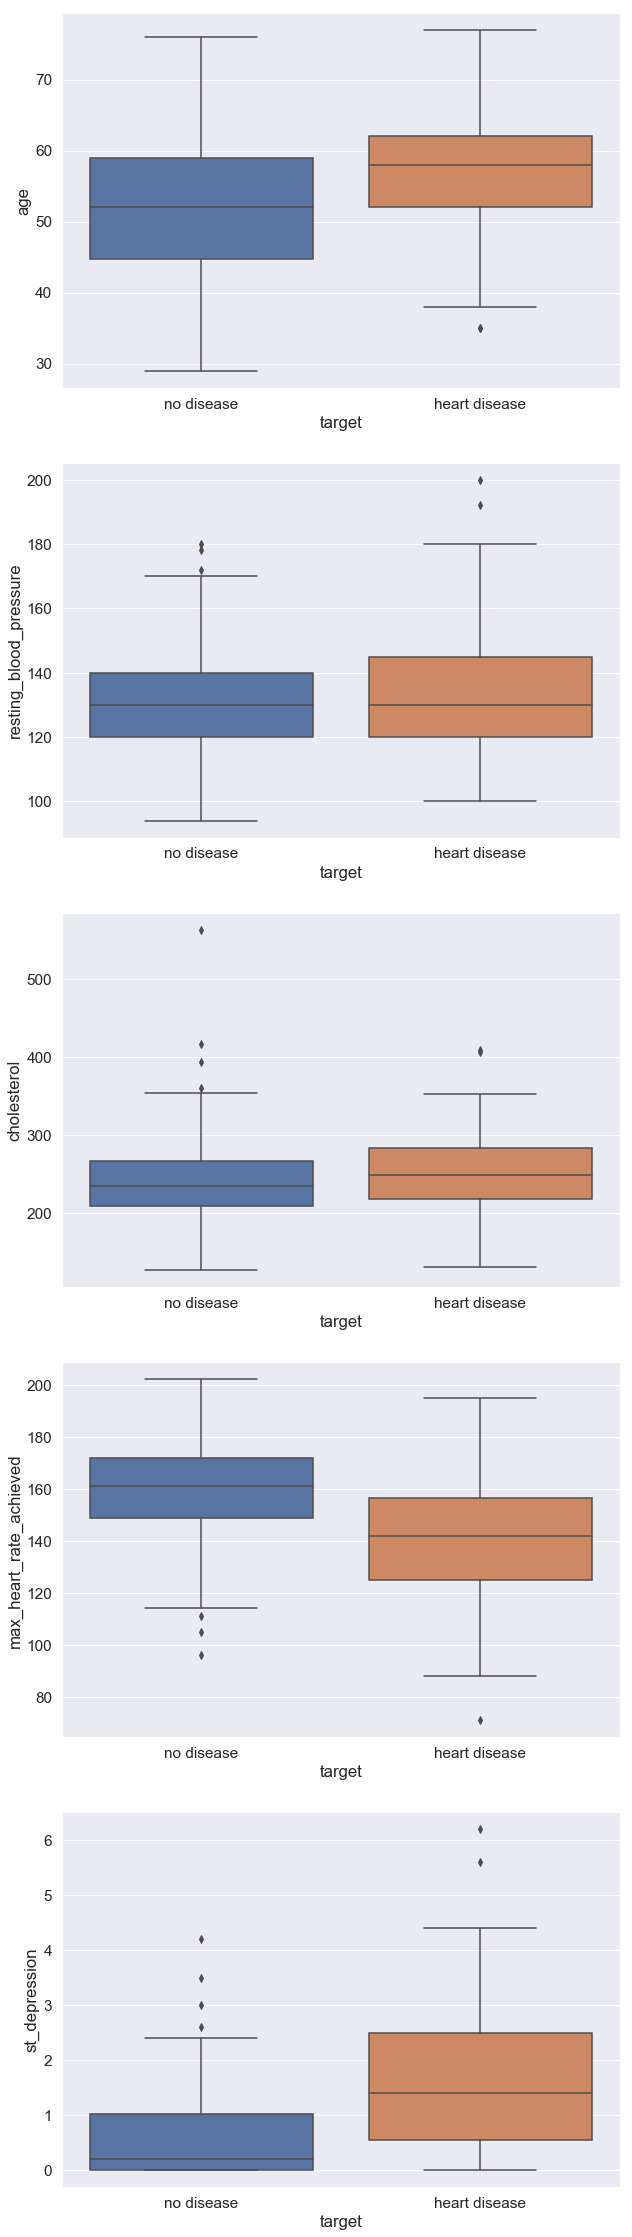

In [31]:
fig, axs = plt.subplots(len(numerical), figsize=(10,40))
for i, c in enumerate(numerical):
    sns.boxplot(x='target', y=c, data=df2, ax=axs[i])
plt.show()

There looks to be a few outliers represented in the data particularly in `cholesterol` and `st_depression`, we will need to remove these as they can negatively impact our Logistic Regression model.

We can use the **Z-Score** to grab these data points and remove them.
> The *Z-Score* is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

We can calulate the Z-score then re-scale and center the data and look for data points which are too far from zero. These data points can then be treated as the outliers. In most cases a threshold of 3 is used.

In [32]:
import scipy.stats as stats
import numpy as np

z = np.abs(stats.zscore(df[numerical]))
threshold = 3
print(np.where(z > 3))

(array([ 48,  91, 121, 123, 126, 152, 181, 188, 245]), array([2, 4, 2, 4, 1, 2, 2, 1, 3]))


Don’t be confused by the results. The first array contains the list of row numbers and second array respective column numbers, which mean `z[48][2]` have a Z-score higher than 3.

In [33]:
z[48][2]

3.2946855640924104

In [34]:
df_o = df.copy()
df_o = df_o.drop(np.where(z>3)[0])

In [35]:
f"Original data shape {df.shape} vs omitted data shape {df_o.shape}"

'Original data shape (303, 14) vs omitted data shape (294, 14)'

Box plots use the **interquartile range (IQR)** to display data and outliers.
> The **interquartile range (IQR)**, also called the **midspread** or **middle 50%**, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, *IQR = Q3 − Q1*.

It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.

In [36]:
Q1 = df[numerical].quantile(0.25)
Q3 = df[numerical].quantile(0.75)
IQR = Q3 - Q1
IQR

age                        13.0
resting_blood_pressure     20.0
cholesterol                64.0
max_heart_rate_achieved    32.5
st_depression               1.6
dtype: float64

As we now have the IQR scores, it's time to get our outliers. The below code will give an output with some true and false values. The data point where we have False means these values are valid whereas True indicates presence of an outlier.

In [37]:
IQR_o = (df[numerical] < (Q1 - 1.5 * IQR)) |(df[numerical] > (Q3 + 1.5 * IQR))
IQR_o.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False


Now we can use several functions here to check if there is `.any()` row that cotains a `True` boolean. And then we can filter the list for only the `True` outliers.

In [38]:
np.where(IQR_o.any('columns'))[0]

array([ 14,  48,  83,  91, 121, 123, 126, 152, 172, 173, 181, 183, 188,
       191, 201, 213, 231, 245, 285])

In [39]:
df_o2 = df.copy()
df_o2 = df_o2.drop(np.where(IQR_o.any('columns'))[0])

In [40]:
f"Original data shape {df.shape} vs omitted data shape {df_o2.shape}"

'Original data shape (303, 14) vs omitted data shape (284, 14)'

As you can see using the IQR omitted 10 extra patients than our Z-score. 

To summarize, bad data or wrong calculation can be identified as Outliers and should be dropped. However if the data represents true outliers of the population you might want correct them instead. 

For example: 5 people get salary of 10K, 20K, 30K, 40K and 50K and suddenly one person starts getting a salary of 100K. Consider this situation as the employer, the new salary update might be seen as biased and you might need to increase other employee’s salary too, to keep the balance. So, there can be multiple reasons you want to understand and correct the outliers.

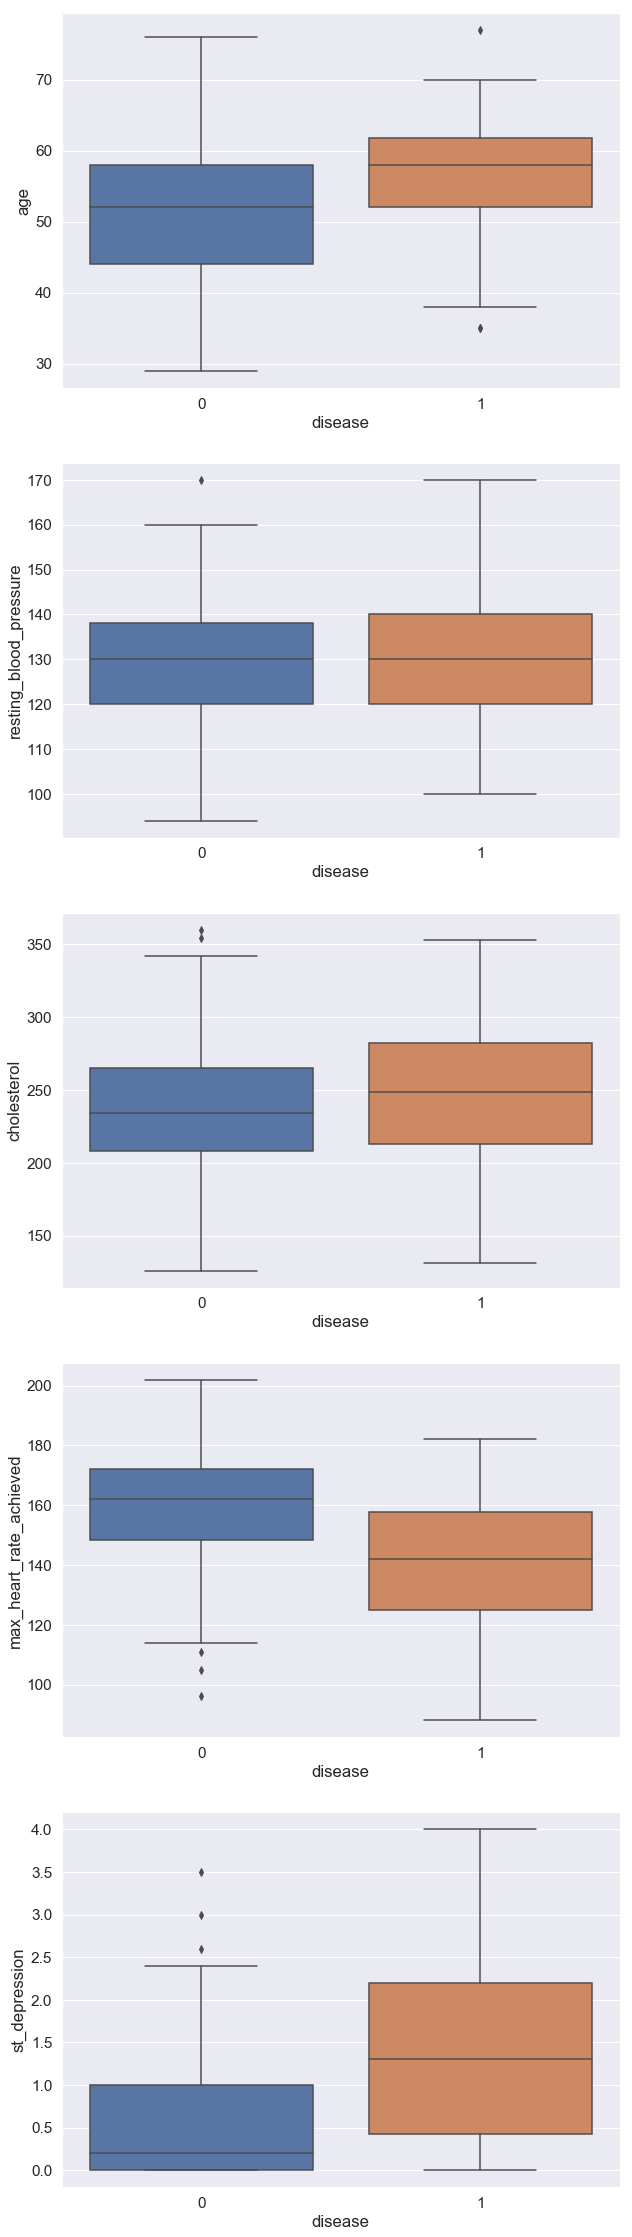

In [41]:
df_o2['disease'] = df_o2['target']
df_o2.loc[df_o2['disease'] > 0, 'disease'] = 1
fig, axs = plt.subplots(len(numerical), figsize=(10,40))
for i, c in enumerate(numerical):
    sns.boxplot(x='disease', y=c, data=df_o2, ax=axs[i])
plt.show()

As you can see now the box plots still show outliers, but the values are not so far away from the rest of the values and can be kept and used in the analysis.

# Logisitic Regression Model
The assumptions have been checked, and the data is good to run.

From here, it's straightforward and plugging in the desired model into the formula. For the categorical variables we can use the dummy variables created to look at multicollinearity or by using the `C(variable)`. 

If using the dummy variables, be sure to not include 1 of the groups to avoid the Dummy Variable Trap. The group dropped is then considered the reference group for the other dummy variables that came from the same original variable. Most commonly, the highest ranked group is dropped. Using the `C(variable)` method automatically does this.

The general structure of the formula is `DV ~ IV1 + IV2 + IVn`

In [42]:
df_o2.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thallium,target,disease
0,63,1,0,145,233,1,2,150,0,2.3,2,0,1,0,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,0,2,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,2,1,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,0,0,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,0,0,0


In [44]:
# Needed to run the logistic regression
import statsmodels.formula.api as smf

model = smf.logit("""disease ~ 
                  age +
                  sex +
                  C(chest_pain_type) +
                  resting_blood_pressure +
                  cholesterol +
                  fasting_blood_sugar +
                  C(rest_ecg) +
                  max_heart_rate_achieved +
                  exercise_induced_angina +
                  st_depression +
                  C(st_slope) +
                  num_major_vessels +
                  C(thallium)
                  """, data=df_o2).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.322426
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                disease   No. Observations:                  284
Model:                          Logit   Df Residuals:                      265
Method:                           MLE   Df Model:                           18
Date:                Wed, 22 May 2019   Pseudo R-squ.:                  0.5305
Time:                        21:20:06   Log-Likelihood:                -91.569
converged:                       True   LL-Null:                       -195.05
                                        LLR p-value:                 4.054e-34
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -7.2853      3.212     -2.268      0.023     -13.580      -0.990
C(chest_pain_type)[T.1]     0.8717      0.771      1.131      0.258      -0.639       2.383
C(chest_pain_type)[T.2]     0.0592      0.658      0.090      0.928      -1.231       1.350
C(chest_pain_type)[T.3]     1.9598      0.669      2.930      0.003       0.649       3.271
C(rest_ecg)[T.1]            0.5914      3.057      0.193      0.847      -5.400       6.583
C(rest_ecg)[T.2]            0.6057      0.396      1.529      0.126      -0.171       1.382
C(st_slope)[T.1]            0.9547      0.475      2.009      0.045       0.023       1.886
C(st_slope)[T.2]            0.8076      0.923      0.875      0.381      -1.000       2.616
C(thallium)[T.1]            0.0508      0.812      0.063      0.950      -1.540       1.641
C(thallium)[T.2]            1.4958      0.447      3.348      0.001       0.620       2.372
age                        -0.0107      0.025     -0.425      0.671      -0.060       0.039
sex                         1.4402      0.543      2.653      0.008       0.376       2.504
resting_blood_pressure      0.0228      0.013      1.727      0.084      -0.003       0.049
cholesterol                 0.0089      0.005      1.772      0.076      -0.001       0.019
fasting_blood_sugar        -0.4232      0.607     -0.697      0.486      -1.613       0.766
max_heart_rate_achieved    -0.0152      0.012     -1.268      0.205      -0.039       0.008
exercise_induced_angina     0.6378      0.460      1.387      0.165      -0.263       1.539
st_depression               0.5066      0.246      2.059      0.039       0.024       0.989
num_major_vessels           1.2246      0.282      4.347      0.000       0.672       1.777
===========================================================================================
"""

## Interpreting Logistic Regression Models
The model summary shows the coefficients, standard error, the associated z-score, and the 95% confidence intervals. We interpret the results as follows, the overall model is significant indicated by a LLR p-value < 0.05 (1.591e-32) which allows us to look at the rest of the results.

Not all the IVs have a significant effect on the log odds of having CAD as indicated by the `P>|z| < 0.05`.

In [45]:
def summary_to_df(model):
    results = pd.DataFrame(model.summary().tables[1])
    cols = results.iloc[0].astype(str)
    cols[0] = "DV"
    results.columns = cols
    results = results.drop(0)
    results = results.set_index('DV')
    results = results.astype(str).astype(float)
    return results

results = summary_to_df(model)
results[results['P>|z|'] < 0.05]

,coef,std err,z,P>|z|,[0.025,0.975]
DV,,,,,,
Intercept,-7.2853,3.212,-2.268,0.023,-13.580,-0.990
C(chest_pain_type)[T.3],1.9598,0.669,2.930,0.003,0.649,3.271
C(st_slope)[T.1],0.9547,0.475,2.009,0.045,0.023,1.886
C(thallium)[T.2],1.4958,0.447,3.348,0.001,0.620,2.372
sex,1.4402,0.543,2.653,0.008,0.376,2.504
st_depression,0.5066,0.246,2.059,0.039,0.024,0.989
num_major_vessels,1.2246,0.282,4.347,0.000,0.672,1.777


### Numeric Variables
Interpreting continuous variables is not very different from interpreting them in a linear regression model. For every one unit increase in the patients st_depression, the log odds of having CAD increase by `0.5066`.

When comparing binary varibles such as sex (0 = male; 1 = female) you simply compare the two values with each other. So increasing the sex value by one unit is actually the female sex. Female patients have an increase in their log odds of having CAD by `1.4402`.

### Categorical Variables
The categorical variables have a different interpretation. Since Rank 1 was dropped from the analysis, it is the comparison group and plays an important role in interpreting the other categories.

**chest_pain_ type:** The chest pain experienced:
- 0 = typical angina
- 1 = atypical angina
- 2 = non-anginal pain
- 3 = asymptomatic

For example, if a patient was asymptomatic (T.3) compared to typical angina (Intercept), there is a `1.9598` increase in the log odds of having CAD.

## Taking Logistic Regression a Step Further
Interpreting the log odds is not very straightforward when thinking about it's effects. An easier way to interpret the findings is by converting the coefficiencts of the logisitic regression model into odd ratios. This can be done by getting the exponent of the coefficient value.

In [46]:
model_odds = pd.DataFrame(np.exp(model.params), columns=['OR'])
model_odds['z-value'] = model.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())
model_odds

,OR,z-value,2.5%,97.5%
Intercept,0.000686,0.023309,0.000001,0.371430
C(chest_pain_type)[T.1],2.391085,0.258131,0.527721,10.833909
C(chest_pain_type)[T.2],1.060995,0.928356,0.291883,3.856716
C(chest_pain_type)[T.3],7.097993,0.003391,1.913186,26.333820
C(rest_ecg)[T.1],1.806450,0.846614,0.004515,722.799521
C(rest_ecg)[T.2],1.832498,0.126193,0.843183,3.982589
C(st_slope)[T.1],2.597794,0.044573,1.023416,6.594127
C(st_slope)[T.2],2.242551,0.381334,0.367697,13.677125
C(thallium)[T.1],1.052140,0.950064,0.214414,5.162898
C(thallium)[T.2],4.462985,0.000814,1.859153,10.713608


Converting the logistic coefficients into odds ratios makes it easier to interpret the effects on the DV. The confidence intervals have been converted to odds as well.

### Numeric Variables
For every one unit increase in the maximum heart rate achieved the odds of having CAD decreases by a factor of `0.985`. Interestingly, the maximum HR, age (`0.998`) and cholesterol (`0.991`) almost play no role in your chances of having CAD.

### Categorical Variables
Still interpreting the results in comparison to the intercept group.

**chest_pain_ type:** The chest pain experienced:
- 0 = typical angina
- 1 = atypical angina
- 2 = non-anginal pain
- 3 = asymptomatic

Patients that attended with atypical angina (T.1) compared to typical angina (Intercept), are `2.391` more likely to have CAD.

When interpreting odd ratios, any value greater than 1 indicates an increase in the odds, i.e. an increase in the likely hood, of that group being in the outcome variable, and any value less than 1 indicates a decrease in the odds, i.e. an decrease in the likely hood.

## Creating a Model for Logistic Regression

We can now use the sklearn library to apply the logistic regression model to future values.

In [47]:
categorical = [
    'chest_pain_type',
    'rest_ecg',
    'st_slope',
    'thallium'
]
df_o2_cat = df.copy()
for category in categorical:
    df_o2_cat[category] = df_o2_cat[category].astype('category')
df_o2_cat = pd.get_dummies(df_o2_cat)
df_o2_cat.columns = df_cat.columns.drop('disease')
df_o2_cat.head()

,age,sex,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,num_major_vessels,target,...,cp_asymmetric,ecg_normal,ecg_ischemic,ecg_LVH,st_upsloping,st_flat,st_downsloping,thal_normal,thal_fixed_defect,thal_reversible
0,63,1,145,233,1,150,0,2.3,0,0,...,0,0,0,1,0,0,1,0,1,0
1,67,1,160,286,0,108,1,1.5,3,2,...,1,0,0,1,0,1,0,1,0,0
2,67,1,120,229,0,129,1,2.6,2,1,...,1,0,0,1,0,1,0,0,0,1
3,37,1,130,250,0,187,0,3.5,0,0,...,0,1,0,0,0,0,1,1,0,0
4,41,0,130,204,0,172,0,1.4,0,0,...,0,0,0,1,1,0,0,1,0,0


In [48]:
from sklearn.model_selection import train_test_split

y = df_o2_cat['target'].values
np.place(y, y>0, 1)
x = df_o2_cat.drop('target', 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state=0)
print(y_test)
x_test.head()

[0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0
 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0]


,age,sex,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,num_major_vessels,cp_typical_angina,...,cp_asymmetric,ecg_normal,ecg_ischemic,ecg_LVH,st_upsloping,st_flat,st_downsloping,thal_normal,thal_fixed_defect,thal_reversible
225,34,0,118,210,0,192,0,0.7,0,0,...,0,1,0,0,1,0,0,1,0,0
152,67,0,115,564,0,160,0,1.6,0,0,...,0,0,0,1,0,1,0,0,0,1
228,54,1,110,206,0,108,1,0.0,1,0,...,1,0,0,1,0,1,0,1,0,0
201,64,0,180,325,0,154,1,0.0,0,0,...,1,1,0,0,1,0,0,1,0,0
52,44,1,112,290,0,153,0,0.0,1,0,...,1,0,0,1,1,0,0,1,0,0


In [49]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs')
lr.fit(x_train,y_train)
print("Train Data Accuracy {:.2f}%".format(lr.score(x_train,y_train)*100))
print("Test Data Accuracy {:.2f}%".format(lr.score(x_test,y_test)*100))

Train Data Accuracy 88.43%
Test Data Accuracy 80.33%


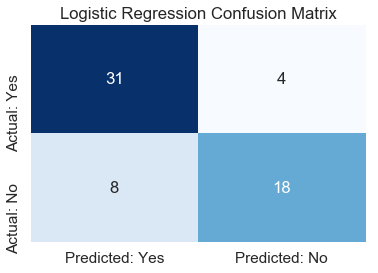

In [50]:
from sklearn.metrics import confusion_matrix

y_head = lr.predict(x_test)
cm_lr = confusion_matrix(y_test,y_head)
cm_df = pd.DataFrame(cm_lr, index=['Actual: Yes', 'Actual: No'], columns=['Predicted: Yes', 'Predicted: No'])
g = sns.heatmap(cm_df,
                annot=True,
                cmap="Blues",
                fmt="d",
                cbar=False,
               )
g.set_title("Logistic Regression Confusion Matrix")
plt.show()

\begin{align}
Sensitivity = \frac{True\:Positives}{True\:Positives + False\:Negatives}
\end{align}

\begin{align}
Specificity = \frac{True\:Negatives}{True\:Negatives + False\:Positives}
\end{align}

In [51]:
total=sum(sum(cm_lr))

sensitivity = cm_lr[0,0]/(cm_lr[0,0]+cm_lr[1,0])
print(f'Sensitivity : {sensitivity*100:.2f}%')

specificity = cm_lr[1,1]/(cm_lr[1,1]+cm_lr[0,1])
print(f'Specificity : {specificity*100:.2f}%')

Sensitivity : 79.49%
Specificity : 81.82%


That seems reasonable. Let's also check with a **[Receiver Operator Curve (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)**,

In [52]:
y_predict = lr.predict(x_test)
y_pred_quant = lr.predict_proba(x_test)[:, 1]
y_pred_bin = lr.predict(x_test)

In [53]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

In [54]:
roc = pd.DataFrame([fpr, tpr]).T
roc.columns = ['fpr', 'tpr']

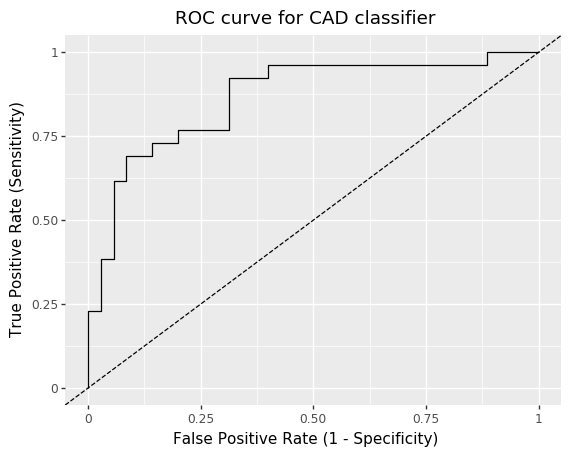

In [55]:
g = (ggplot(roc, aes(x='fpr', y='tpr'))
     + geom_line()
     + geom_abline(intercept=0, linetype='--')
     + labs(
         title='ROC curve for CAD classifier',
         x='False Positive Rate (1 - Specificity)',
         y='True Positive Rate (Sensitivity)'
     )
    ).draw()
g.show()

Another common metric is the **Area Under the Curve**, or **AUC**. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail

Let's see what the above ROC gives us:

In [56]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.8648351648351649

# Explaning the Model

Now let's see what the model gives us from the ML explainability tools.

**Permutation importance** is the first tool for understanding a machine-learning model, and involves shuffling individual variables in the validation data (after a model has been fit), and seeing the effect on accuracy. Learn more [here](https://www.kaggle.com/dansbecker/permutation-importance).

In [57]:
from eli5 import show_weights
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lr, random_state=1).fit(x_test, y_test)
show_weights(perm, 
             feature_names=x_test.columns.tolist())

Weight,Feature
0.0623 ± 0.0889,num_major_vessels
0.0492 ± 0.0359,max_heart_rate_achieved
0.0295 ± 0.0131,thal_normal
0.0295 ± 0.0245,sex
0.0197 ± 0.0245,thal_reversible
0.0197 ± 0.0131,cp_typical_angina
0.0131 ± 0.0245,st_upsloping
0.0098 ± 0.0161,cholesterol
0.0098 ± 0.0334,cp_asymmetric
0.0066 ± 0.0445,age


So, it looks like the most important factors in terms of permutation is the 'number of major vessels' visualized by fluoroscopy. The high importance of 'max heart rate achieved' makes sense, as this is the immediate, subjective state of the patient at the time of examination (as opposed to, say, age, which is a much more general factor).

Let's take a closer look at the number of major vessles using a **Partial Dependence Plot** (learn more [here](https://www.kaggle.com/dansbecker/partial-plots)). These plots vary a single variable in a single row across a range of values and see what effect it has on the outcome. It does this for several rows and plots the average effect.

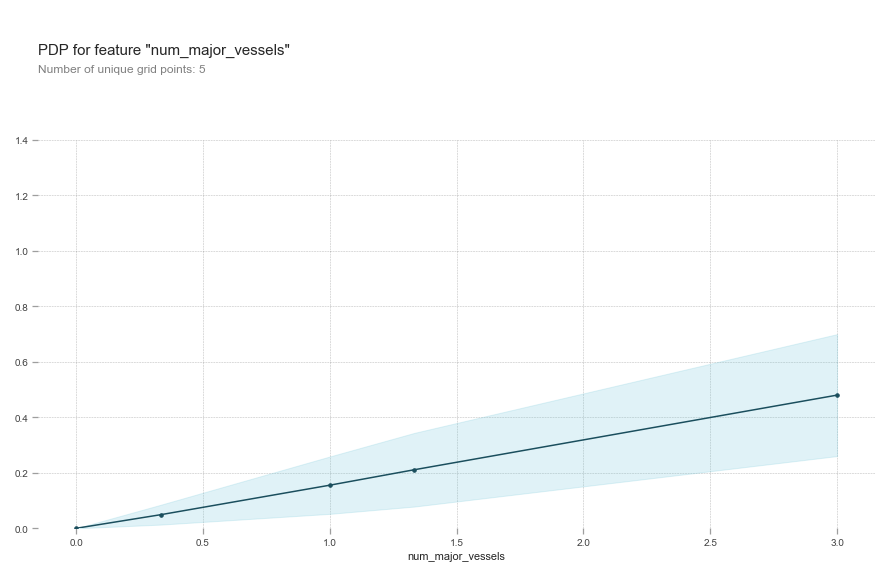

In [58]:
from pdpbox.pdp import pdp_isolate, pdp_plot

base_features = x_train.columns.tolist()

feat_name = 'num_major_vessels'
pdp_dist = pdp_isolate(model=lr, 
                       dataset=x_test, 
                       model_features=base_features, 
                       feature=feat_name)

pdp_plot(pdp_dist, feat_name)
plt.show()

So, we can see that as the number of major blood vessels *increases*, the probability of heart disease *increases*. Which is strange, because if major vessels were not visualized then surely they would be narrow/blocked?

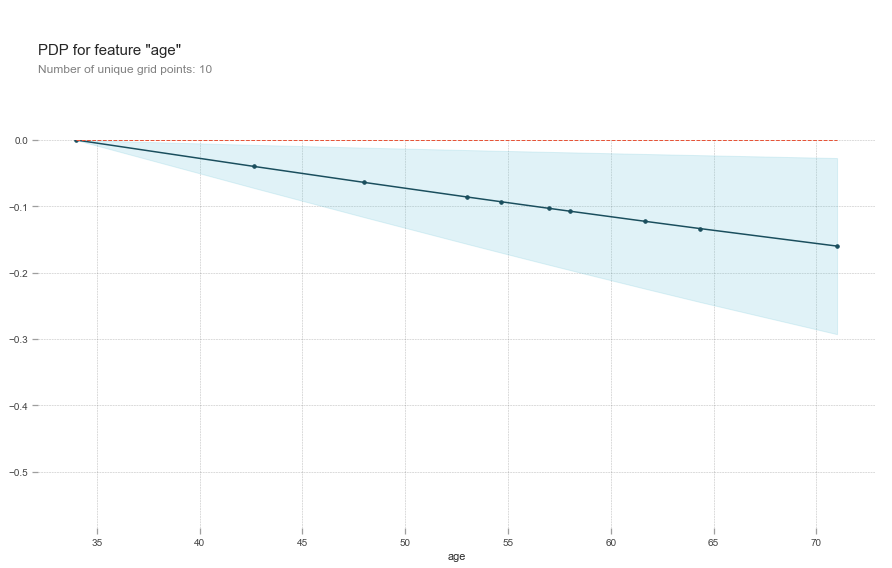

In [59]:
feat_name = 'age'
pdp_dist = pdp_isolate(model=lr, 
                       dataset=x_test, 
                       model_features=base_features, 
                       feature=feat_name)

pdp_plot(pdp_dist, feat_name)
plt.show()

That's a bit odd. The higher the age, the lower the chance of heart disease?

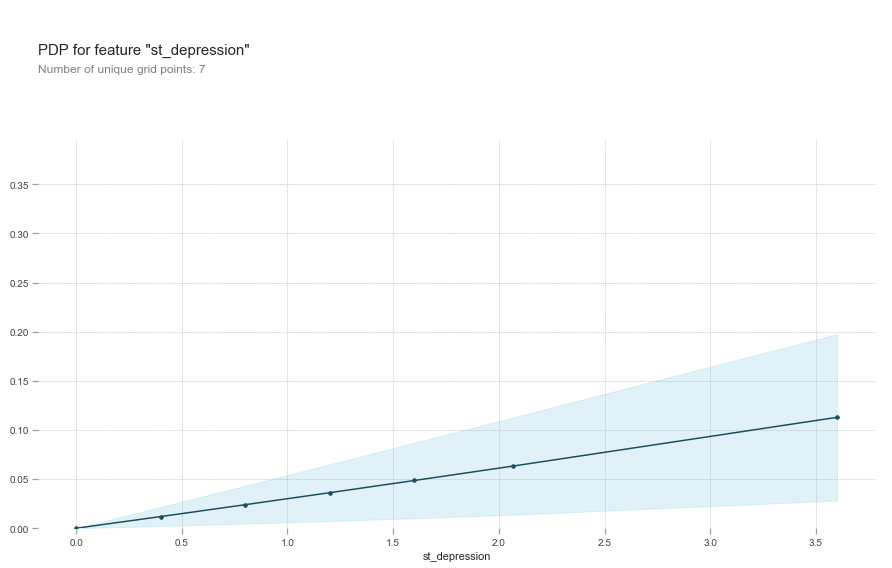

In [60]:
feat_name = 'st_depression'
pdp_dist = pdp_isolate(model=lr, 
                       dataset=x_test, 
                       model_features=base_features, 
                       feature=feat_name)

pdp_plot(pdp_dist, feat_name)
plt.show()

So, this variable, which is described as 'ST depression induced by exercise relative to rest', seems to suggest the larger the ST depression the higher the probability of heart disease.

# Conclusion

This dataset is old and small by today's standards. However, it's allowed us to create a simple model and then use various machine learning explainability tools and techniques to peek inside. At the start, I hypothesised that factors such as cholesterol and age would be major factors in the model. This dataset didn't show this. Instead, the number of major factors and aspects of ECG results dominated.

I suspect this sort of approach will become increasingly important as machine learning has a greater and greater role in health care.